In [1]:
import re 
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, train_test_split 
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras import Model

import tensorflow as tf
from keras import layers
from keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix

2024-11-26 21:20:40.759792: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/jianhongxu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [11]:
train_df = pd.read_csv("/Users/jianhongxu/python_project/twitter_dataset/data/train_dataset_85k.csv")
test_df = pd.read_csv("/Users/jianhongxu/python_project/twitter_dataset/data/test_dataset_85k.csv")
train_df.head()

,tweet,class
0,marked as toread have you seen me by kate whit...,ADHD
1,s dominance in the is under threat after the t...,DEPRESSION
2,surprises the obsession of mr king on trump,BIPOLAR
3,i started on medium but moved to tumblr a i d...,DEPRESSION
4,i look forward to hearing more,BIPOLAR


In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')

stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jianhongxu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
def remove_number_stopwords(text):
    num = re.compile(r'[-+]?[.\d]*[\d]+[:,.\d]*')
    text = num.sub(r'',text)
    text = ' '.join([word for word in text.split() if word not in (stopwords)])
    return text
train_df['clean_tweet'] = train_df['tweet'].apply(remove_number_stopwords)
test_df['clean_tweet'] = test_df['tweet'].apply(remove_number_stopwords)

In [15]:
train_df.head(10)

,tweet,class,clean_tweet
0,marked as toread have you seen me by kate whit...,ADHD,marked toread seen kate white httpurl
1,s dominance in the is under threat after the t...,DEPRESSION,dominance threat third round mens platform fin...
2,surprises the obsession of mr king on trump,BIPOLAR,surprises obsession mr king trump
3,i started on medium but moved to tumblr a i d...,DEPRESSION,started medium moved tumblr didnt like medium ...
4,i look forward to hearing more,BIPOLAR,look forward hearing
5,such objects stimuli mental rotation wikipedi...,ADHD,objects stimuli mental rotation wikipedia xref...
6,all they would have to do is say we think the...,ADHD,would say think constituiton doesnt give feder...
7,wow i absolutely love when professors waste my...,ADHD,wow absolutely love professors waste time class
8,quality products the how to temporarily cure ...,ADHD,quality products temporarily cure hyperactivit...
9,id been trying to pay attention to my symptoms...,DEPRESSION,id trying pay attention symptoms pre cycle not...


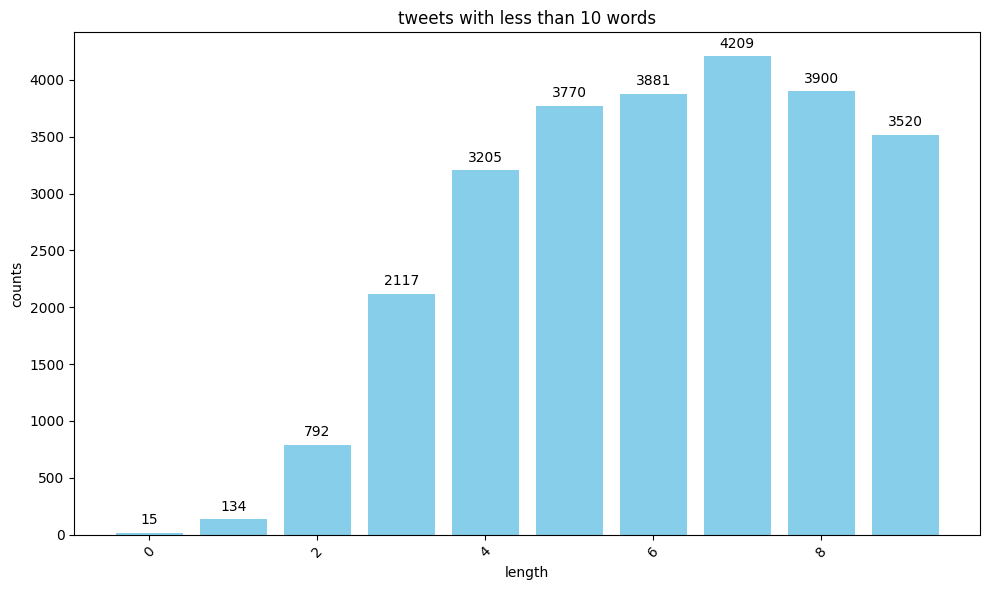

In [17]:
import matplotlib.pyplot as plt
def word_count(text):
    if isinstance(text,str):
        return len(text.split())
    return 0

train_df['text_len'] = train_df['clean_tweet'].apply(word_count)
test_df['text_len'] = test_df['clean_tweet'].apply(word_count)


text_num = train_df['text_len'].value_counts().reset_index(name='counts')

df_filtered = text_num[text_num['text_len']<10]

plt.figure(figsize=(10,6))
bars =plt.bar(df_filtered['text_len'], df_filtered['counts'], color='skyblue')

plt.xlabel('length')
plt.ylabel('counts')
plt.title('tweets with less than 10 words')
plt.xticks(rotation=45)
plt.tight_layout()

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()+bar.get_width()/2,yval+50,yval,ha='center',va='bottom')
plt.show()

In [18]:
train_df = train_df[train_df["text_len"]>4]
test_df = test_df[test_df["text_len"]>4]
train_df['class'].value_counts()

class
ADHD          21633
DEPRESSION    21162
BIPOLAR       19248
Name: count, dtype: int64

In [19]:
from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
train_df['labels'] = labelEncoder.fit_transform(train_df['class'])
test_df['labels'] = labelEncoder.fit_transform(test_df['class'])

train_df[['class','labels']].drop_duplicates(keep='first')

,class,labels
0,ADHD,0
1,DEPRESSION,2
2,BIPOLAR,1


In [22]:

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['clean_tweet'])

word_index = tokenizer.word_index
print(word_index)
vocab_size = len(tokenizer.word_index)+1
print(vocab_size)
max_length = train_df['clean_tweet'].apply(lambda x:len(str(x).split())).max()
print(max_length)

{'httpurl': 1, 'im': 2, 'like': 3, 'people': 4, 'dont': 5, 'amp': 6, 'one': 7, 'get': 8, 'know': 9, 'time': 10, 'think': 11, 'would': 12, 'ive': 13, 'even': 14, 'really': 15, 'want': 16, 'good': 17, 'work': 18, 'thats': 19, 'still': 20, 'also': 21, 'need': 22, 'going': 23, 'make': 24, 'see': 25, 'right': 26, 'much': 27, 'book': 28, 'cant': 29, 'go': 30, 'got': 31, 'way': 32, 'day': 33, 'never': 34, 'youre': 35, 'love': 36, 'feel': 37, 'things': 38, 'back': 39, 'could': 40, 'well': 41, 'years': 42, 'new': 43, 'life': 44, 'didnt': 45, 'today': 46, 'say': 47, 'someone': 48, 'something': 49, 'first': 50, 'said': 51, 'always': 52, 'take': 53, 'actually': 54, 'us': 55, 'lol': 56, 'thing': 57, 'better': 58, 'world': 59, 'doesnt': 60, 'year': 61, 'many': 62, 'adhd': 63, 'read': 64, 'every': 65, 'last': 66, 'trying': 67, 'sure': 68, 'person': 69, 'lot': 70, 'hes': 71, 'made': 72, 'look': 73, 'help': 74, 'best': 75, 'shit': 76, 'find': 77, 'ill': 78, 'getting': 79, 'ever': 80, 'man': 81, 'though

In [24]:
train_texts = tokenizer.texts_to_sequences(train_df['clean_tweet'])
train_texts = pad_sequences(train_texts,maxlen=max_length)

test_texts = tokenizer.texts_to_sequences(test_df['clean_tweet'])
test_texts = pad_sequences(test_texts,maxlen=max_length)
print(f'train shape: {train_texts.shape}, test shape: {test_texts.shape}')




train shape: (62043, 56), test shape: (15564, 56)


In [36]:
train_labels = pd.get_dummies(train_df['labels'], dtype=int)
train_labels = train_labels.values
test_labels = pd.get_dummies(test_df['labels'], dtype=int)
train_labels

array([[1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0]])

In [26]:
GLOVE_PATH = '/Users/jianhongxu/python_project/twitter_dataset/glove.6B.100d.txt'

embeddings_index = {}

f = open(GLOVE_PATH, encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embeddings_index[word] =coefs
f.close()

print(f'Found {len(embeddings_index)} word vectors.')

EMBEDDING_DIM = 100
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


In [42]:
model = Sequential()
model.add(layers.Input(shape=(train_texts.shape[1],)))
model.add(layers.Embedding(
    input_dim=vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_matrix],input_length=max_length))
model.add(layers.Dropout(0.3))
model.add(layers.Bidirectional(layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(32, activation='swish'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(3, activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/Users/jianhongxu/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 56, 100)        │     4,704,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 56, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,740,827 (18.08 MB)

 Trainable params: 4,740,827 (18.08 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:

kf = KFold(n_splits=5, shuffle=True, random_state=42)



accuracy_per_fold = []
fold_no = 1
histories = []  # List to store histories

for train_index, val_index in kf.split(train_texts):
    
    print(f'Fold {fold_no}')
    
    train_text, val_text = train_texts[train_index], train_texts[val_index]
    train_label, val_label = train_labels[train_index], train_labels[val_index]

    history = model.fit(train_text, train_label, epochs=2, verbose=1, 
                        validation_data=(val_text,val_label))
    
    histories.append(history)

    scores = model.evaluate(val_text, val_label, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[1]} of {scores[1]*100:.2f}%')
    accuracy_per_fold.append(scores[1]*100)

    fold_no +=1


print('Average accuracy:', np.mean(accuracy_per_fold))

Fold 1
Epoch 1/2
1552/1552 ━━━━━━━━━━━━━━━━━━━━ 156s 97ms/step - accuracy: 0.4628 - loss: 1.0215 - val_accuracy: 0.6406 - val_loss: 0.7826
Epoch 2/2
1552/1552 ━━━━━━━━━━━━━━━━━━━━ 126s 81ms/step - accuracy: 0.6503 - loss: 0.7716 - val_accuracy: 0.6978 - val_loss: 0.6777
Score for fold 1: compile_metrics of 69.78%
Fold 2
Epoch 1/2
1552/1552 ━━━━━━━━━━━━━━━━━━━━ 138s 89ms/step - accuracy: 0.7148 - loss: 0.6612 - val_accuracy: 0.7865 - val_loss: 0.5271
Epoch 2/2
1552/1552 ━━━━━━━━━━━━━━━━━━━━ 136s 85ms/step - accuracy: 0.7615 - loss: 0.5682 - val_accuracy: 0.7871 - val_loss: 0.5075
Score for fold 2: compile_metrics of 78.71%
Fold 3
Epoch 1/2
1552/1552 ━━━━━━━━━━━━━━━━━━━━ 131s 84ms/step - accuracy: 0.7811 - loss: 0.5285 - val_accuracy: 0.8491 - val_loss: 0.3852
Epoch 2/2
1552/1552 ━━━━━━━━━━━━━━━━━━━━ 158s 95ms/step - accuracy: 0.8083 - loss: 0.4651 - val_accuracy: 0.8438 - val_loss: 0.3851
Score for fold 3: compile_metrics of 84.38%
Fold 4
Epoch 1/2
1552/1552 ━━━━━━━━━━━━━━━━━━━━ 102s 66

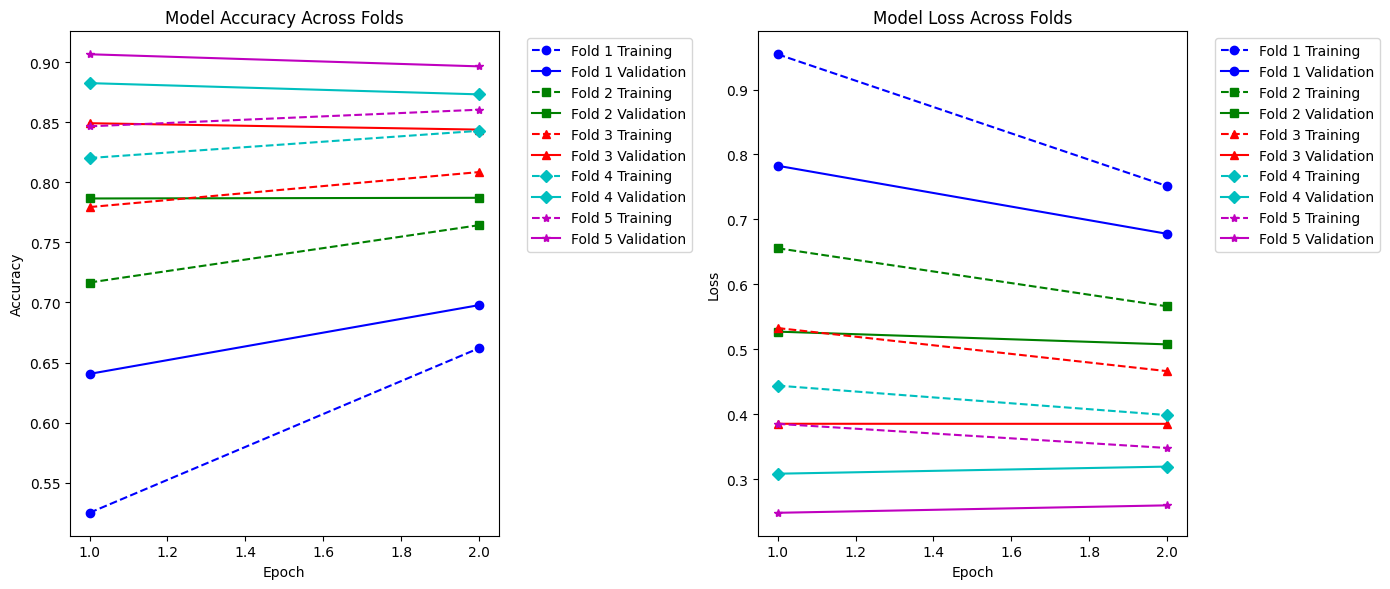

In [45]:
# Initialize the figure
plt.figure(figsize=(14, 6))

# Create subplots
plt.subplot(1, 2, 1)  # For accuracy
# Initialize lists to keep track of legend labels
train_acc_lines = []
val_acc_lines = []

plt.subplot(1, 2, 2)  # For loss
train_loss_lines = []
val_loss_lines = []

# Define markers and colors for different folds
markers = ['o', 's', '^', 'D', '*', 'v', 'h', '8', 'p', '>']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:orange', 'tab:pink', 'tab:purple']

for i, history in enumerate(histories):
    epochs_range = range(1, len(history.history['accuracy']) + 1)
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    # Training accuracy
    line1, = plt.plot(epochs_range, history.history['accuracy'],
                      marker=markers[i % len(markers)],
                      color=colors[i % len(colors)],
                      linestyle='--',
                      label=f'Fold {i+1} Training')
    # Validation accuracy
    line2, = plt.plot(epochs_range, history.history['val_accuracy'],
                      marker=markers[i % len(markers)],
                      color=colors[i % len(colors)],
                      linestyle='-',
                      label=f'Fold {i+1} Validation')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    # Training loss
    plt.plot(epochs_range, history.history['loss'],
             marker=markers[i % len(markers)],
             color=colors[i % len(colors)],
             linestyle='--',
             label=f'Fold {i+1} Training')
    # Validation loss
    plt.plot(epochs_range, history.history['val_loss'],
             marker=markers[i % len(markers)],
             color=colors[i % len(colors)],
             linestyle='-',
             label=f'Fold {i+1} Validation')

# Finalize accuracy subplot
plt.subplot(1, 2, 1)
plt.title('Model Accuracy Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Finalize loss subplot
plt.subplot(1, 2, 2)
plt.title('Model Loss Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


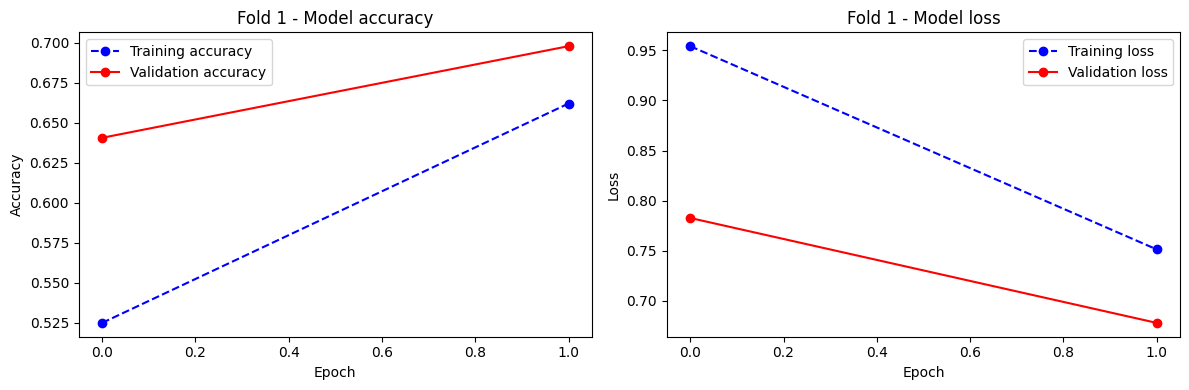

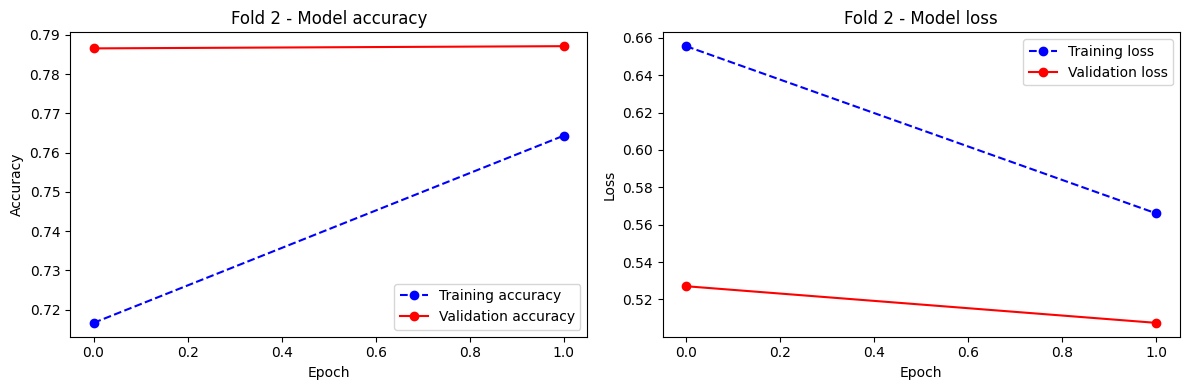

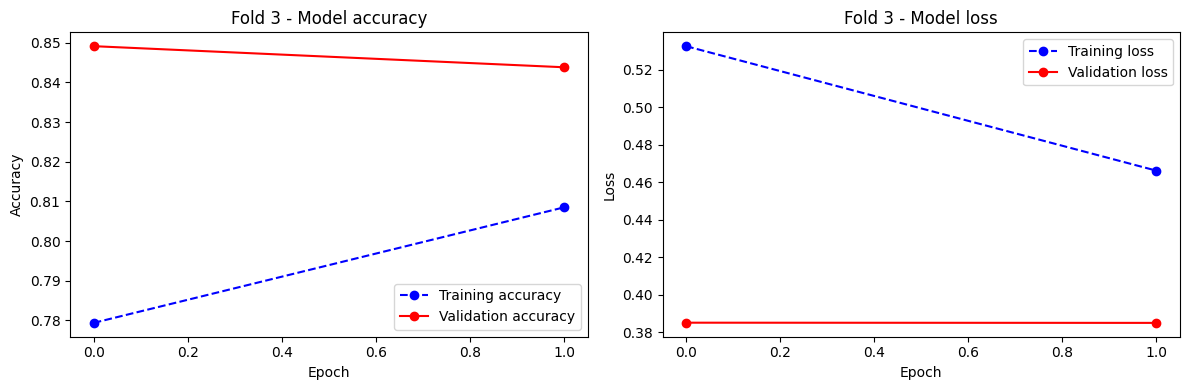

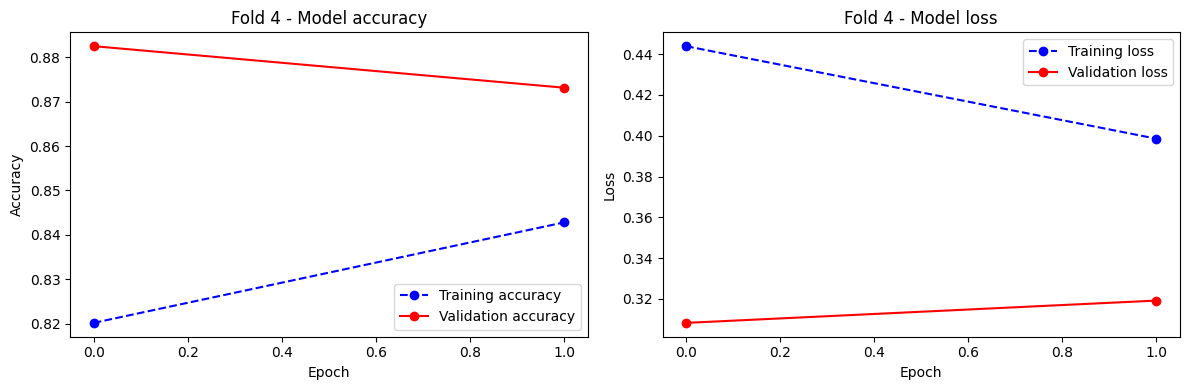

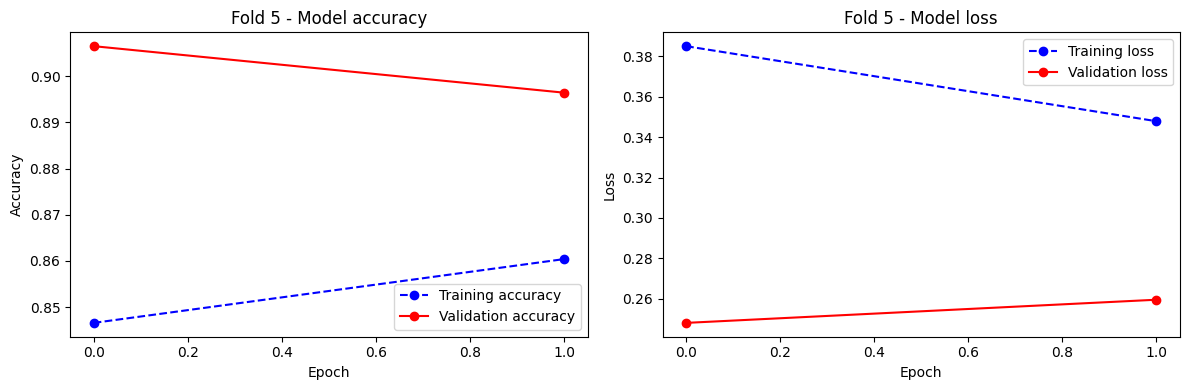

In [44]:
for i, history in enumerate(histories):
    # Summarize history for accuracy
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], 'bo--', label='Training accuracy')
    plt.plot(history.history['val_accuracy'], 'ro-', label='Validation accuracy')
    plt.title(f'Fold {i+1} - Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], 'bo--', label='Training loss')
    plt.plot(history.history['val_loss'], 'ro-', label='Validation loss')
    plt.title(f'Fold {i+1} - Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# x = range(1, len(acc)+1)

# plt.figure(figsize=(12,5))
# plt.subplot(1,2,1)
# plt.plot(x, loss, label='Training Loss')
# plt.plot(x, val_loss, label ='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss over Epochs')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(x, acc, label='Training Accuracy')
# plt.plot(x, val_acc, label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy Over Epochs')
# plt.legend()

# plt.tight_layout()
# plt.show()

487/487 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step


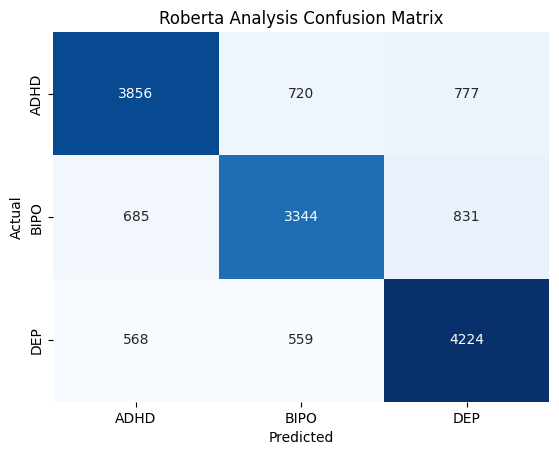

              precision    recall  f1-score   support

        ADHD       0.75      0.72      0.74      5353
     BIPOLAR       0.72      0.69      0.71      4860
  DEPRESSION       0.72      0.79      0.76      5351

    accuracy                           0.73     15564
   macro avg       0.73      0.73      0.73     15564
weighted avg       0.73      0.73      0.73     15564



In [46]:
predict = model.predict(test_texts)
predict = np.argmax(predict,axis=1)
predict = np.array(predict)

lables = test_labels.idxmax(axis=1)

conf_matrix = confusion_matrix(lables, predict)
labels=["ADHD", "BIPO", "DEP"]
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g', cbar=False)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Roberta Analysis Confusion Matrix')
plt.show()

print(classification_report(lables, predict, target_names=["ADHD", "BIPOLAR", "DEPRESSION"]))